In [66]:
from rdflib import Graph, Namespace, Literal, BNode, URIRef
import os
import getpass
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.schema import Document
from sklearn.cluster import KMeans
import json

In [58]:
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

In [30]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=N7f354840f7bc4cf58b9d6b6afbbe75b0 (<class 'rdflib.graph.Graph'>)>

In [33]:
# Load jsonld file
data = json.load(open("data/dunbar/bacnet.jsonld"))

In [50]:
# Create the documents to load into the vector store
documents = []

# Loop through the jsonld file and create a document for each
for i in range(0, len(data)):
    # Check if its a bacnet device or point
    type = data[i]["@type"][0]
    if type == "http://data.ashrae.org/bacnet/2016#bacnet_Point":
        device_name = data[i]['http://data.ashrae.org/bacnet/2016#device_name'][0]['@value']
        point_name = data[i]['http://data.ashrae.org/bacnet/2016#object_name'][0]['@value']
        present_value = data[i]['http://data.ashrae.org/bacnet/2016#present_value'][0]['@value']
        unit = data[i]['http://data.ashrae.org/bacnet/2016#object_units'][0]['@value']

        # Create the document
        content = device_name + " " + point_name + " " + present_value + " " + unit
        documents.append(Document(page_content=content, metadata={"type": "bacnet_point", }))

In [62]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [65]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

In [81]:
# use a predefined number of clusters
num_clusters = 25

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_assignments = kmeans.fit_predict(embs)
cluster_assignments

/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([ 3, 19,  6, ..., 19, 12,  4], dtype=int32)

In [82]:
# Use the cluster assignments to create a dictionary of clusters
clusters = {}
for i in range(0, len(cluster_assignments)):
    cluster = cluster_assignments[i]
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(documents[i].page_content)

clusters

{3: ['VAV-D2-28 7A37VavOccupM active ',
  'VAV-D2-28 7A37DmpCmd 3 ',
  "DOAS-3&5 VAV'S M5DOAS3POINTSHARE-PRG  UNKNOWN UNITS",
  'VAV-D2-52 3A30DmpStatus 28.0 percent',
  'VAV-D2-55 3A35HighCO2 inactive ',
  'VAV-D2-39 3A6-Space-Co2 0.0 noUnits',
  'VAV-D2-56 3A34DmpStatus 0.0 percent',
  'VAV-D2-24 7A31-Space-Co2 0.0 noUnits',
  'VAV-D2-38 3A13DmpCmd 3 ',
  'VAV-D2-2 7A20VavLocBalOvr 0.0 noUnits',
  'VAV-D2-45 3A42VavOccupM active ',
  'VAV-D2-52 3A30DmpCmd 3 ',
  'VAV-D2-20 7A43VavCalFac 610.0 noUnits',
  'VAV-D2-15 7A47DmpStatus 21.0 percent',
  'VAV-D2-50 3A37VavOccupM active ',
  "DOAS-3&5 VAV'S M6DOAS5-DMPR-HL 0.0 noUnits",
  'VAV-D2-6 7A18VavOccupM active ',
  'VAV-D2-9 7A14Co2SP 600.0 megajoulesPerSquareMeter',
  'VAV-D2-25 7A34HighCO2 inactive ',
  'VAV-D2-55 3A35DmpStatus 29.0 percent',
  'DHW HW-HX-VAVLE 0.0 percent',
  'VAV-D2-30 3A19-Space-Co2 0.0 noUnits',
  'VAV-D2-33 3A4UnoccCoolMode inactive ',
  'VAV-D2-46 3A41DmpStatus 19.0 percent',
  'VAV-D2-54 3A32VavCalFac 175.0 n

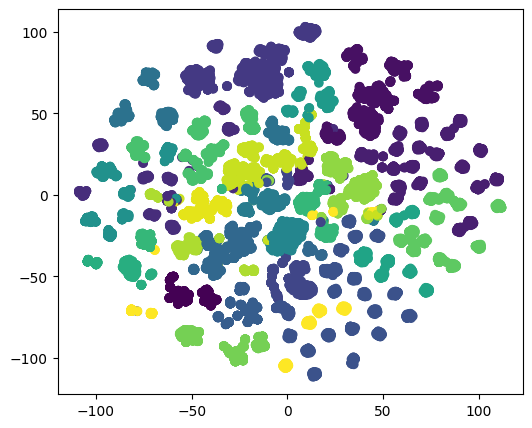

In [83]:
# Plot the clusters
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Convert list to numpy array
embs_array = np.array(embs)

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embs_array)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_assignments)
plt.show()